In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

In [4]:
!pip install split-folders

import splitfolders
splitfolders.ratio('/content/drive/MyDrive/machine learning projects/training set/Rice_Image_Dataset', output="output", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 75000 files [52:29, 23.82 files/s] 


In [5]:
BATCH = 64
IMG_WIDTH = 96
IMG_HEIGHT = 96

In [6]:
train_loader = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=BATCH
)

test_loader = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=BATCH
)

validation_loader = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=BATCH
)

Found 60000 files belonging to 5 classes.
Found 7500 files belonging to 5 classes.
Found 7500 files belonging to 5 classes.


In [7]:
class_names = train_loader.class_names
print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


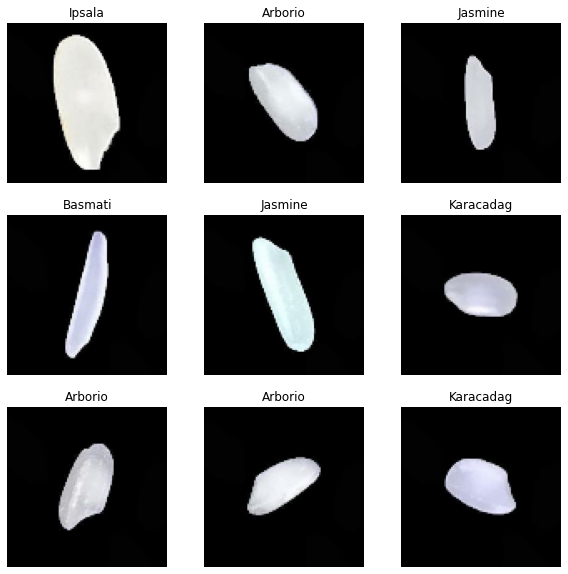

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_loader.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_loader.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_loader.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = validation_loader.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [11]:
model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
  
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names))
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                  

In [15]:
epochs = 50
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/50
938/938 [==============================] - 732s 780ms/step - loss: 0.1509 - accuracy: 0.9479 - val_loss: 0.1005 - val_accuracy: 0.9649
Epoch 2/50
938/938 [==============================] - 711s 758ms/step - loss: 0.0930 - accuracy: 0.9692 - val_loss: 0.0794 - val_accuracy: 0.9724
Epoch 3/50
938/938 [==============================] - 709s 756ms/step - loss: 0.0489 - accuracy: 0.9843 - val_loss: 0.1464 - val_accuracy: 0.9471
Epoch 4/50
938/938 [==============================] - 720s 767ms/step - loss: 0.0360 - accuracy: 0.9883 - val_loss: 0.0380 - val_accuracy: 0.9880
Epoch 5/50
938/938 [==============================] - 707s 753ms/step - loss: 0.0283 - accuracy: 0.9912 - val_loss: 0.1024 - val_accuracy: 0.9635
Epoch 6/50
938/938 [==============================] - 709s 756ms/step - loss: 0.0221 - accuracy: 0.9927 - val_loss: 0.0905 - val_accuracy: 0.9677
Epoch 7/50
938/938 [==============================] - 718s 766ms/step - loss: 0.0228 - accuracy: 0.9930 - val_loss: 0.1406 -

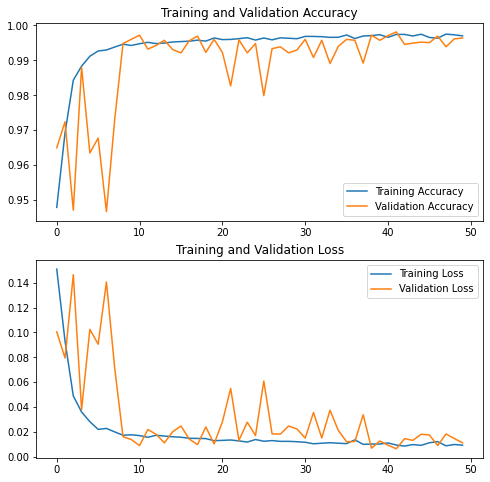

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
loss, accuracy = model.evaluate(test_dataset)

118/118 [==============================] - 30s 248ms/step - loss: 0.0125 - accuracy: 0.9968


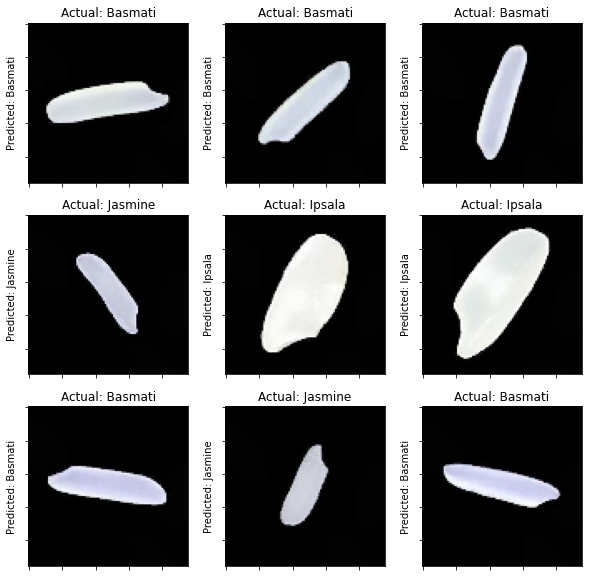

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in test_loader.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        plt.ylabel("Predicted: "+class_names[np.argmax(score)])
        plt.title("Actual: "+class_names[labels[i]])
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])